In [1]:
# GOES on AWS python utility: https://github.com/palexandremello/goes-py
!pip install goespy

# GOES on AWS: https://docs.opendata.aws/noaa-goes16/cics-readme.html ; https://registry.opendata.aws/noaa-goes/
# https://nbviewer.jupyter.org/github/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_TrueColor.ipynb

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Install these basemap packages from conda-forge
!conda install --yes -c conda-forge basemap-data-hires

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda:

The following NEW packages will be INSTALLED:

    basemap-data-hires: 1.2.0-0 conda-forge

basemap-data-h 100% |################################| Time: 0:00:01 109.22 MB/s


In [28]:
# Install elevation
!pip install elevation

  Using cached https://files.pythonhosted.org/packages/b8/9a/e55570fa28fbe3106da6ac9a5df0156c39647551171e10de45624069a917/elevation-1.0.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/14/3a/096c7ad18e102d4f219f5dd15951f9728ca5092a3385d2e8f79a7c1e1017/fasteners-0.14.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/56/eb/810e700ed1349edde4cbdc1b2a21e28cdf115f9faf263f6bbf8447c1abf3/appdirs-1.4.3-py2.py3-none-any.whl
    100% |████████████████████████████████| 71kB 2.8MB/s 
  Using cached https://files.pythonhosted.org/packages/ac/aa/063eca6a416f397bd99552c534c6d11d57f58f2e94c14780f3bbf818c4cf/monotonic-1.5-py2.py3-none-any.whl
  Found existing installation: Click 7.0
    Uninstalling Click-7.0:
      Successfully uninstalled Click-7.0
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
%matplotlib inline
#%matplotlib widget

import rasterio as rio
import rasterio.plot
from pyproj import Proj
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import elevation
import os
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
from goespy.Downloader import ABI_Downloader # https://github.com/palexandremello/goes-py


======================================== goes-py =========================================
 A Python package can be useful to download dataset from goes satellite on AWS  0.2.1v


In [2]:
# AWS S3 Buckets to search for GOES-16 and -17
buckets = ['noaa-goes16','noaa-goes17']
# Specify date, time, product, band (channel)
year='2019'
month='01'
day='13'
hour='18'
product='ABI-L1b-RadC'
channel='C14'
# Local paths where data will be stored
paths = ['/home/jovyan/goes16', '/home/jovyan/goes17'] # or if at home 'C:/Users/steve/goes16'
filepath = []; # store filepaths of the files we download

In [3]:
# For each S3 bucket, download the corresponding observations
for i in range(len(buckets)):
    filepath.append('{}/{}/{}/{}/{}/{}/{}/'.format(paths[i],year,month,day,product,hour,channel))
    if not os.path.exists(filepath[i]):
        ABI = ABI_Downloader(buckets[i],year,month,day,hour,product,channel)

In [4]:
bucket_n=0
file_list = os.listdir(filepath[bucket_n])
file_list

['OR_ABI-L1b-RadC-M3C14_G16_s20190131837173_e20190131839546_c20190131839593.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131852173_e20190131854546_c20190131854591.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131807173_e20190131809546_c20190131809592.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131842173_e20190131844546_c20190131844591.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131832173_e20190131834546_c20190131834590.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131802173_e20190131804546_c20190131804593.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131857173_e20190131859546_c20190131859589.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131822173_e20190131824546_c20190131824592.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131817173_e20190131819546_c20190131819593.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131847173_e20190131849546_c20190131849592.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131812173_e20190131814546_c20190131814591.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190131827173_e20190131829546_c20190131829589.nc']

In [5]:
# pick a file from this list
file_n = 0
file = filepath[bucket_n] + file_list[file_n]

In [6]:
# open dataset using xarray
C = xr.open_dataset(filepath[bucket_n] + file_list[file_n])

In [7]:
def getProj4string(goes_imager_projection):
    '''make a proj4 string  and a pyproj geostationary map object from goes imager projection information'''
    h=goes_imager_projection.perspective_point_height
    a=goes_imager_projection.semi_major_axis
    rf=goes_imager_projection.inverse_flattening
    lon0=goes_imager_projection.longitude_of_projection_origin
    lat0=goes_imager_projection.latitude_of_projection_origin
    sweep=goes_imager_projection.sweep_angle_axis
    proj_string = '"+proj=geos +ellps=GRS80 +h={h} +a={a} +rf={rf} +lon_0={lon0} +lat_0={lat0} +sweep={sweep}"'.format(
        h=h,a=a,rf=rf,lon0=lon0,lat0=lat0,sweep=sweep)
    p = Proj(proj='geos', h=h, lon_0=lon0, sweep=sweep)
    return proj_string, p

In [8]:
# make a proj4 string and a pyproj geostationary map object from this file's projection information
proj_string, p = getProj4string(C.goes_imager_projection)

In [9]:
def getLatLon(sat_x,sat_y,sat_h,R,p):
    
    # See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
    x = sat_x * sat_h
    y = sat_y * sat_h
    # Perform cartographic transformation. That is, convert image projection coordinates (x and y)
    # to latitude and longitude values.
    XX, YY = np.meshgrid(x, y)
    lons, lats = p(XX, YY, inverse=True)

    # Assign the pixels showing space as a single point in the Gulf of Alaska
    lats[np.isnan(R)] = 57
    lons[np.isnan(R)] = -152
    
    # Replace in radiance values nans
    R[np.isnan(R)] = -9999.0
    
    return lats, lons, R

In [10]:
# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
sat_h = C.goes_imager_projection.perspective_point_height
sat_x = C['x'][:]
sat_y = C['y'][:]
Rad = C['Rad'].data

lats16, lons16, R16 = getLatLon(sat_x,sat_y,sat_h,Rad,p)


In [11]:
# Or use an orthographic projection
mL = Basemap(resolution='i', projection='ortho', 
              lat_0=35, lon_0=-100)

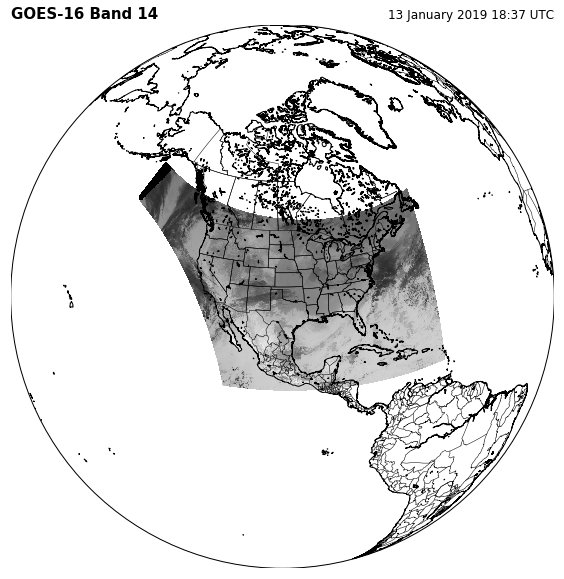

In [12]:
plt.figure(figsize=[10, 10])

# Plotting radiances on our map
newmap = mL.pcolormesh(lons16, lats16, R16, cmap='gray', vmin=0, linewidth=0, latlon=True)

mL.drawcoastlines()
mL.drawcountries()
mL.drawstates()

plt.title('GOES-16 Band 14', loc='left', fontweight='semibold', fontsize=15)
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ') # Scan's start time, converted to datetime object
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC'), loc='right');
plt.savefig('images/GOES-16_b14.png')

In [13]:
# Repeat the same to add GOES-17 to the plot

In [14]:
# select the GOES-17 path
bucket_n = 1
file_list = os.listdir(filepath[bucket_n])

# pick a file from this list
file_n = 0
file = filepath[bucket_n] + file_list[file_n]

# open dataset using xarray
C_17 = xr.open_dataset(filepath[bucket_n] + file_list[0])

In [15]:
# make a proj4 string  and a pyproj geostationary map object from this file's projection information
proj_string, p = getProj4string(C_17.goes_imager_projection)


# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
sat_h = C_17.goes_imager_projection.perspective_point_height
sat_x = C_17['x'][:]
sat_y = C_17['y'][:]
Rad = C_17['Rad'].data

lats17, lons17, R17 = getLatLon(sat_x,sat_y,sat_h,Rad,p)


In [16]:
# Or use an orthographic projection
mL = Basemap(resolution='i', projection='ortho', 
              lat_0=35, lon_0=-120)

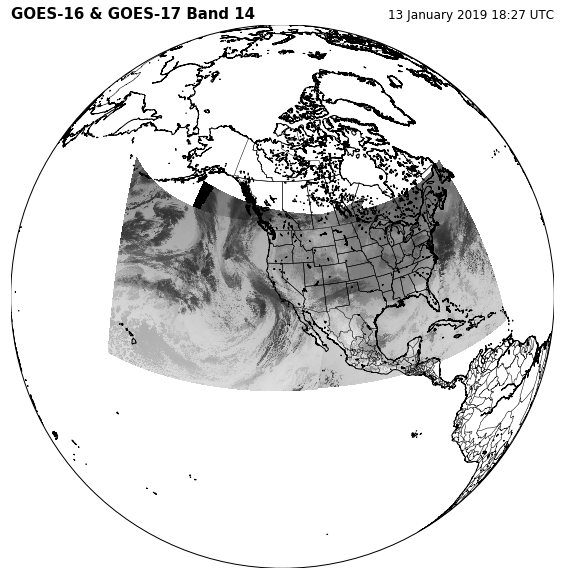

In [17]:
plt.figure(figsize=[10, 10])

# Plotting radiances on our map
g16 = mL.pcolormesh(lons16, lats16, R16, cmap='gray',vmin=0, linewidth=0, latlon=True)
g17 = mL.pcolormesh(lons17, lats17, R17, cmap='gray',vmin=0, linewidth=0, latlon=True)

mL.drawcoastlines()
mL.drawcountries()
mL.drawstates()

plt.title('GOES-16 & GOES-17 Band 14', loc='left', fontweight='semibold', fontsize=15)
scan_start = datetime.strptime(C_17.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ') # Scan's start time, converted to datetime object
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC'), loc='right');
plt.savefig('images/GOES-16-17_b14.png')

In [18]:
# Make a zoomed-in plot of the Sierra Nevadas

In [19]:
# Load a higher resolution band (band 3, NIR)

# AWS S3 Buckets to search for GOES-16 and -17
buckets = ['noaa-goes16','noaa-goes17']
# Specify date, time, product, band (channel)
year='2019'
month='01'
day='13'
hour='18'
product='ABI-L1b-RadC'
channel='C03'
# Local paths where data will be stored
paths = ['/home/jovyan/goes16', '/home/jovyan/goes17'] # or if at home 'C:/Users/steve/goes16'
filepath = []; # store filepaths of the files we download

In [20]:
# For each S3 bucket, download the corresponding observations
for i in range(len(buckets)):
    filepath.append('{}/{}/{}/{}/{}/{}/{}/'.format(paths[i],year,month,day,product,hour,channel))
    if not os.path.exists(filepath[i]):
        ABI = ABI_Downloader(buckets[i],year,month,day,hour,product,channel)

In [21]:
# select the GOES-16 path
bucket_n = 0
file_list = os.listdir(filepath[bucket_n])

# pick a file from this list
file_n = 0
file = filepath[bucket_n] + file_list[file_n]

# open dataset using xarray
C_16 = xr.open_dataset(filepath[bucket_n] + file_list[0])

# make a proj4 string  and a pyproj geostationary map object from this file's projection information
proj_string, p = getProj4string(C_16.goes_imager_projection)

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
sat_h = C_16.goes_imager_projection.perspective_point_height
sat_x = C_16['x'][:]
sat_y = C_16['y'][:]
Rad = C_16['Rad'].data

lats16, lons16, R16 = getLatLon(sat_x,sat_y,sat_h,Rad,p)

In [22]:
# select the GOES-17 path
bucket_n = 1
file_list = os.listdir(filepath[bucket_n])

# pick a file from this list
file_n = 0
file = filepath[bucket_n] + file_list[file_n]

# open dataset using xarray
C_17 = xr.open_dataset(filepath[bucket_n] + file_list[0])

# make a proj4 string  and a pyproj geostationary map object from this file's projection information
proj_string, p = getProj4string(C_17.goes_imager_projection)

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
sat_h = C_17.goes_imager_projection.perspective_point_height
sat_x = C_17['x'][:]
sat_y = C_17['y'][:]
Rad = C_17['Rad'].data

lats17, lons17, R17 = getLatLon(sat_x,sat_y,sat_h,Rad,p)

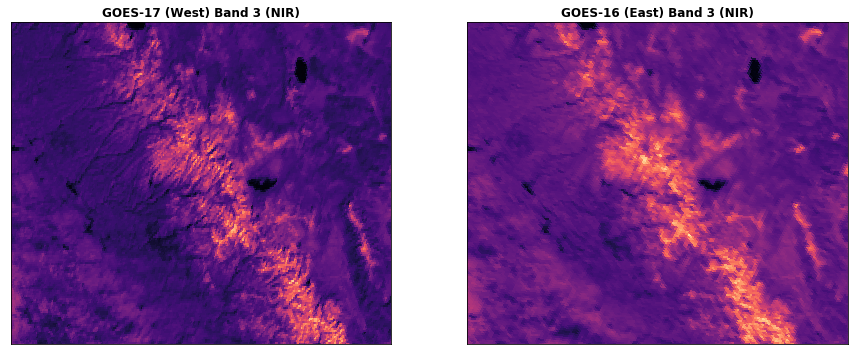

In [23]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=[15, 10])

# Create a map around our area of interest (lower left lon & lat, upper right lon & lat)
sierras_map_17 = Basemap(llcrnrlon=-121,llcrnrlat=37,urcrnrlon=-118,urcrnrlat=39,
             resolution='i', projection='merc', ax=ax1)
sierras_map_16 = Basemap(llcrnrlon=-121,llcrnrlat=37,urcrnrlon=-118,urcrnrlat=39,
             resolution='i', projection='merc', ax=ax2)


# GOES-17 (West)
g17 = sierras_map_17.pcolormesh(lons17, lats17, R17, cmap='magma',vmin=0, vmax=200, linewidth=0, latlon=True)
ax1.set_title('GOES-17 (West) Band 3 (NIR)', loc='center', fontweight='semibold', fontsize=12);

# GOES-16 (East)
g16 = sierras_map_16.pcolormesh(lons16, lats16, R16, cmap='magma',vmin=0, vmax=200, linewidth=0, latlon=True)
ax2.set_title('GOES-16 (East) Band 3 (NIR)', loc='center', fontweight='semibold', fontsize=12);


In [24]:
# Save each subplot
extent = ax1.get_window_extent().transformed(f.dpi_scale_trans.inverted())
f.savefig('images/GOES-17_NIR.png', bbox_inches=extent.expanded(1.1, 1.1))
extent = ax2.get_window_extent().transformed(f.dpi_scale_trans.inverted())
f.savefig('images/GOES-16_NIR.png', bbox_inches=extent.expanded(1.1, 1.1))

In [25]:
# SRTM DEM

In [26]:
#Set some variables for the SRTM dataset
srtm_bounds = (-121, 37, -118, 39)
cache_dir='/home/jovyan/elevation'
product='SRTM3'
output='srtm_%s_full.tif' % product

In [27]:
# Get the SRTM DEMs
elevation.seed(bounds=srtm_bounds, cache_dir=cache_dir, product=product, max_download_tiles=999)

'/home/jovyan/elevation/SRTM3'

In [28]:
!ls $cache_dir/$product/cache

srtm_12_05.tif	     srtm_13_05.tif	  srtm.vrt
srtm_12_05.tif.lock  srtm_13_05.tif.lock


In [29]:
!gdalbuildvrt $cache_dir/$product/cache/srtm.vrt $cache_dir/$product/cache/srtm_12_05.tif $cache_dir/$product/cache/srtm_13_05.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [30]:
srtm = rasterio.open('{}/{}/cache/srtm.vrt'.format(cache_dir,product))

In [31]:
srtm_elev = srtm.read(1)
srtm_elev_masked = ma.masked_values(srtm_elev, srtm.nodata)

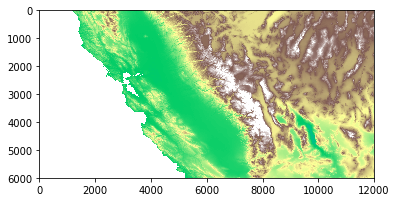

In [32]:
plt.imshow(srtm_elev_masked, cmap='terrain', vmin=-1000, vmax=3000)